## Climate time series analysis
* Charge and preprocess data
* Time series clustering 
* Causal analysis

In [1]:
import pandas as pd
import numpy as np
import os
import datetime
from tensorflow.keras import layers, Model
from tslearn.clustering import TimeSeriesKMeans
import geopandas as gpd
import matplotlib.pyplot as plt

In [3]:
col_names = pd.read_csv('../dades/col_names.txt', header=None)
df = pd.DataFrame()

df.loc[:,'timestamp'] = pd.read_csv('../dades/data_per_pix/-0.5,-48.5.csv', header=None).loc[:,0].apply(datetime.datetime.fromtimestamp)

In [4]:
variables_names = ['Lag_RN_ERA_Ix5day_2', 'Lag_SM_GLEAM_ResPlusTrend_Sx5day_2','maxTXx_cum_T_ERA_2', 'monthly_Rx1day_P_CPCU']
variables_ind = [1486, 2109, 4225, 5007]

In [5]:
df = np.empty((len(os.listdir('../test_data/data_per_pix/')),384,4))
pixels = []
i = 0

for file in os.listdir('../test_data/data_per_pix/'):
    df[i,:,:] = pd.read_csv(os.path.join('../test_data/data_per_pix/', file), header=None).iloc[:, variables_ind]
    i += 1
    pixels.append(file)

In [6]:
inp = layers.Input(shape=(df.shape[1], df.shape[2]))
    

encoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(inp)
encoder = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(encoder)
latent = layers.TimeDistributed(layers.Dense(1, activation='tanh'))(encoder)
decoder = layers.TimeDistributed(layers.Dense(10, activation='tanh'))(latent)
decoder = layers.TimeDistributed(layers.Dense(50, activation='tanh'))(decoder)
out = layers.TimeDistributed(layers.Dense(4))(decoder)

autoencoder = Model(inputs=inp, outputs=out)
autoencoder.compile(optimizer='adam', loss='mse')


autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 4)]          0         
                                                                 
 time_distributed (TimeDistr  (None, 384, 50)          250       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 384, 10)          510       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 384, 1)           11        
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 384, 10)          20        
 tributed)                                                   

In [7]:
ind = np.random.permutation(df.shape[0])
training_idx, test_idx = ind[:80], ind[80:]
x_train, x_test = df[training_idx,:,:], df[test_idx,:,:]

In [8]:
history = autoencoder.fit(x_train, x_train, epochs = 10000, validation_data= (x_test, x_test))

Epoch 1/10000
3/3 [==============================] - 1s 97ms/step - loss: 26327.2246 - val_loss: 26653.3379
Epoch 2/10000
3/3 [==============================] - 0s 22ms/step - loss: 26312.8066 - val_loss: 26641.2363
Epoch 3/10000
3/3 [==============================] - 0s 20ms/step - loss: 26300.9219 - val_loss: 26627.1309
Epoch 4/10000
3/3 [==============================] - 0s 20ms/step - loss: 26286.3184 - val_loss: 26608.8184
Epoch 5/10000
3/3 [==============================] - 0s 19ms/step - loss: 26268.0195 - val_loss: 26588.3828
Epoch 6/10000
3/3 [==============================] - 0s 21ms/step - loss: 26247.9023 - val_loss: 26567.2266
Epoch 7/10000
3/3 [==============================] - 0s 19ms/step - loss: 26226.8223 - val_loss: 26545.5938
Epoch 8/10000
3/3 [==============================] - 0s 20ms/step - loss: 26205.1055 - val_loss: 26523.3828
Epoch 9/10000
3/3 [==============================] - 0s 20ms/step - loss: 26182.8125 - val_loss: 26500.4824
Epoch 10/10000
3/3 [========

In [9]:
encoder = Model(inputs=inp, outputs=latent)
encoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 384, 4)]          0         
                                                                 
 time_distributed (TimeDistr  (None, 384, 50)          250       
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 384, 10)          510       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 384, 1)           11        
 tributed)                                                       
                                                                 
Total params: 771
Trainable params: 771
Non-trainable params: 0
_____________________________________________________________

In [10]:
data = encoder.predict(df)

4/4 [==============================] - 0s 3ms/step


In [11]:
data = data.reshape((len(os.listdir('../test_data/data_per_pix/')), 384))

In [12]:
data = pd.DataFrame(data, index = pixels)

In [13]:
from tslearn.clustering import TimeSeriesKMeans

model = TimeSeriesKMeans(n_clusters=5, metric="dtw", max_iter=100)
model.fit(data)

TimeSeriesKMeans(max_iter=100, metric='dtw', n_clusters=5)

In [14]:
results = pd.DataFrame()

In [15]:
results['group'] = model.predict(data)


c:\Users\Usuario\anaconda3\lib\site-packages\tslearn\utils\utils.py:88: UserWarning: 2-Dimensional data passed. Assuming these are 117 1-dimensional timeseries
  warnings.warn('2-Dimensional data passed. Assuming these are '


In [21]:
coord_x = []
coord_y = []

for i in range(len(pixels)):
    pixels[i] = pixels[i].replace('.csv', '')
    coord_x.append(float(pixels[i].split(',')[1]))
    coord_y.append(float(pixels[i].split(',')[0]))

In [22]:
results['coord_x'] = coord_x
results['coord_y'] = coord_y


In [23]:
results

,group,coord_x,coord_y
0,0,-48.5,-0.5
1,2,-49.5,-0.5
2,2,-50.5,-0.5
3,2,-51.5,-0.5
4,2,-52.5,-0.5
...,...,...,...
112,1,138.5,67.5
113,1,139.5,67.5
114,1,140.5,67.5
115,1,141.5,67.5


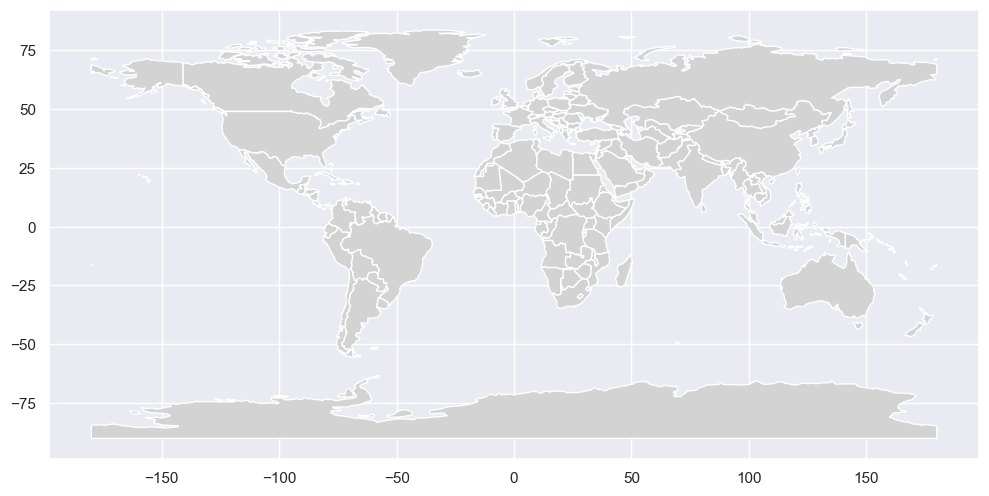

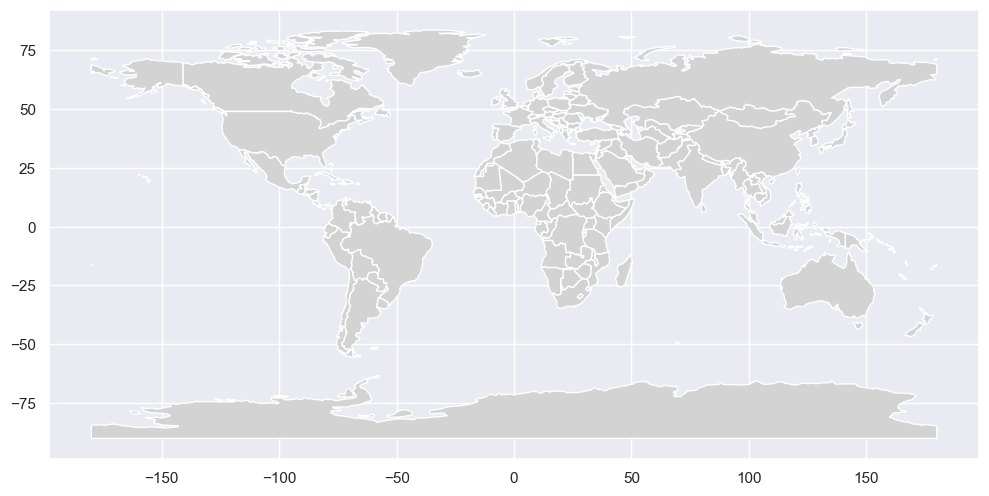

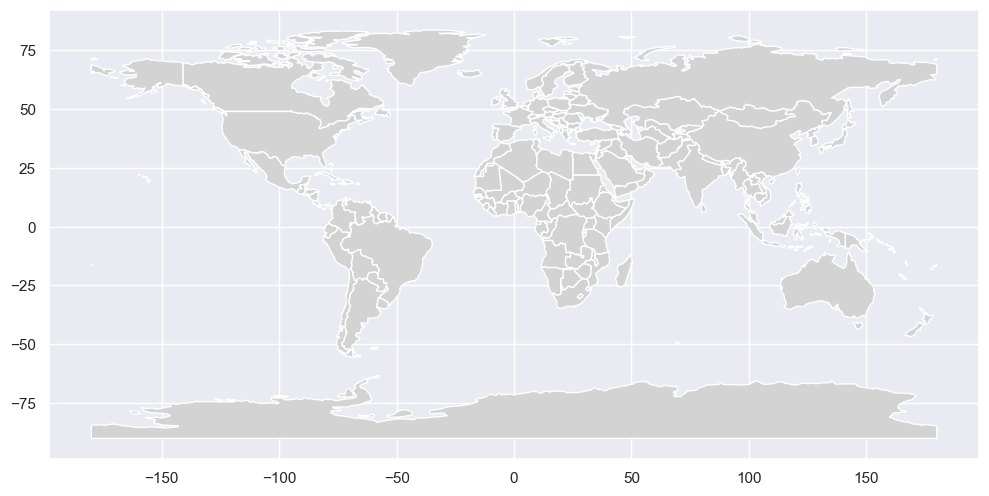

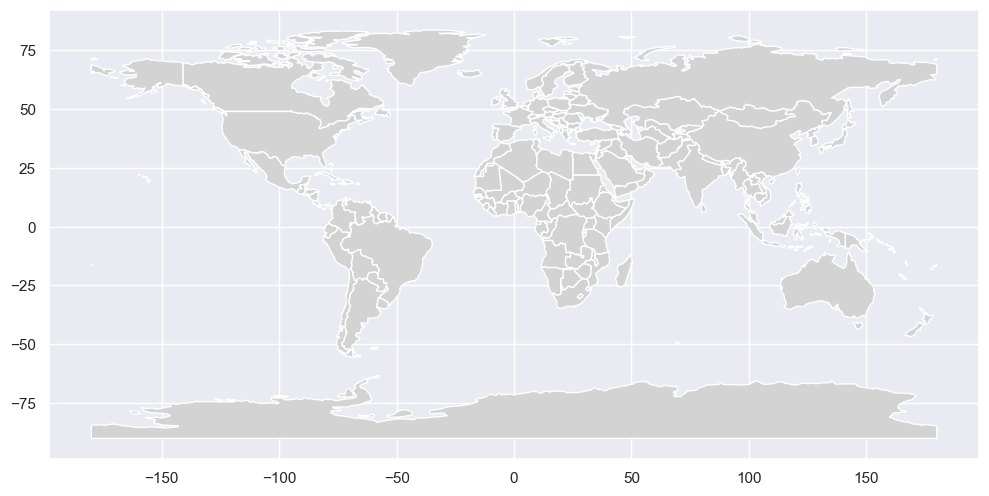

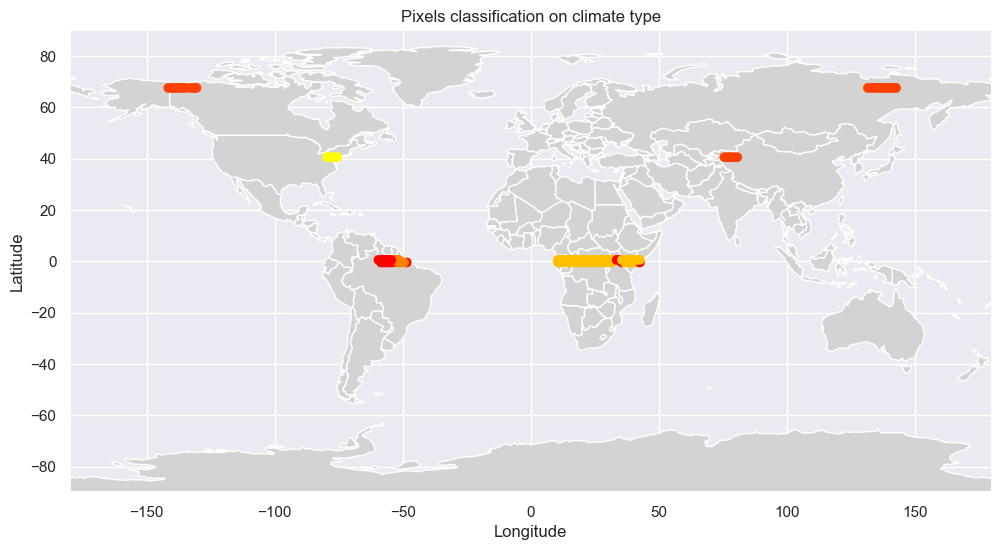

In [41]:
# From GeoPandas, our world map data
worldmap = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Creating axes and plotting world map
fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)


# Plotting our pixels classification by climate type
x = tuple(results['coord_x'])
y = tuple(results['coord_y'])
z = tuple(results['group'])


plt.scatter(x, y, c=z, cmap='autumn')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.title('Pixels classification on climate type')
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()